In [43]:
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# add the path to my packages to system paths so they can be imported
import sys
# sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/simgraph/code/my_packages')
sys.path.append('F:/Users/yasam/Documents/GitHub/simgraph/code/my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import dataprocess.data_handler_03 as dh
import simgraph.my_simgraph as sg

# XGBoost
Regression to predict the summed activities.

## Load spike data

In [2]:
# load all spike data from file
spikes_dp = '../../../local_data/original_files/'
grouped_data = np.load(spikes_dp+'summed_spikes.npy') # you can load alternative files from the same directory

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

In [3]:
grouped_data.shape

(297, 1141, 1)

In [4]:
# visualize the response data
length = grouped_data.shape[0] * grouped_data.shape[1]
lbl_min = int(np.min(grouped_data))
lbl_max = int(np.max(grouped_data))
print('labels range from {} to {}.'.format(lbl_min, lbl_max))

print('label      | percentage belonging to label   ')
print('---------------------------------------------')
sanity = 0
for lbl in range(lbl_min, lbl_max+1):
    class_perc = 100*float(sum(sum(grouped_data == lbl))) / length
    print('label #{:3} | {:.2f} %'.format(lbl, class_perc))
    sanity += class_perc

print("total percentage (should be %100): ", sanity)

labels range from 0 to 26.
label      | percentage belonging to label   
---------------------------------------------
label #  0 | 31.53 %
label #  1 | 15.38 %
label #  2 | 8.77 %
label #  3 | 7.07 %
label #  4 | 6.27 %
label #  5 | 5.61 %
label #  6 | 4.82 %
label #  7 | 4.22 %
label #  8 | 3.67 %
label #  9 | 3.12 %
label # 10 | 2.60 %
label # 11 | 2.07 %
label # 12 | 1.61 %
label # 13 | 1.19 %
label # 14 | 0.80 %
label # 15 | 0.52 %
label # 16 | 0.31 %
label # 17 | 0.18 %
label # 18 | 0.11 %
label # 19 | 0.06 %
label # 20 | 0.04 %
label # 21 | 0.02 %
label # 22 | 0.01 %
label # 23 | 0.01 %
label # 24 | 0.00 %
label # 25 | 0.00 %
label # 26 | 0.00 %
total percentage (should be %100):  100.00000000000003


## Load movie feature set

In [5]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::4]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::200]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::10]*10000

def transform_soenet(fv):
    return fv[::5]

# data retrieval params
# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/soenet/soenet3/features_2layer/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_soenet, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'soenet'}

In [67]:
train_num = 100
val_num = 50

train_num, val_num, train_data, val_data = \
dh.random_train_val(train_num, val_num, data_params, seed=0)

# optional normalization
# train_data['des'] = dh.normalize(train_data['des'])
# val_data['des'] = dh.normalize(val_data['des'])

# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])

print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])
print('minimum value of train features: ', np.min(train_data['des']))
print('mean value of train features: ', np.mean(train_data['des']))
print('median value of train features: ', np.median(train_data['des']))
print('maximum value of train features: ', np.max(train_data['des']))

feature_id:  sift3d
train_num =  100 , val_num =  50
number of features:  77
train_smpls =  [1994 2025 2012 1146 2253 1414 1163 1475 1365 1553 1143 1306 2086 1195
 1427 1984 1449 2192 1149 1591 2270 1364 1705 1283 1228 1967 1905 1622
 1557 1781 1316 1915 1706 2147 1921 1175 1578 1641 1658 1686 2167 2244
 1269 1181 1836 1774 1170 1698 2056 1937 1505 1862 1885 1711 1754 1396
 1837 1387 1421 2139 1718 2193 2090 1320 1447 1689 1883 1865 1697 1895
 1907 1216 2130 1193 2185 1539 1853 2022 1408 2251 1824 1753 1409 2138
 1524 1646 1992 2007 1552 1403 1541 1564 1790 1198 1218 2217 2049 1232
 1813 1362] 
val_smpls =  [1487 1576 1511 1205 2234 2153 1875 1636 2141 1680 1879 1955 2229 1750
 1773 2001 1638 1709 2242 2197 1962 1778 2117 1821 1242 2228 1496 1818
 1916 1223 1983 1791 2008 2006 1470 1860 2037 1538 2102 1922 2065 1649
 2202 1684 1606 2183 2105 1260 1551 1157]
train_lbls =  [ 1.  3.  0.  1.  1.  3.  0.  5.  4.  0.  0. 10.  1.  1.  7.  0.  1.  6.
  3.  1.  1.  3.  5.  2.  0.  2.  8.  0.  1

## Create DMatrices from numpy arrays

In [43]:
# create xgb Dmatrices directly from numpy arrays
dtrain = xgb.DMatrix(train_data['des'], label=train_data['lbls'])
dval = xgb.DMatrix(val_data['des'], label=val_data['lbls'])

# dtrain_x = xgb.DMatrix(train_data['des'])
# dtrain_y = xgb.DMatrix(train_data['lbls'])
# dval_x = xgb.DMatrix(val_data['des'])
# dval_y = xgb.DMatrix(val_data['lbls'])

In [44]:
print('Train Dmatrix shape: {} x {}'.format(dtrain.num_row(), dtrain.num_col()))
print('Val Dmatrix shape: {} x {}'.format(dval.num_row(), dval.num_col()))
print('Train Dmatrix labels: ', dtrain.get_label())
print('Val Dmatrix labels: ', dval.get_label())

Train Dmatrix shape: 100 x 77
Val Dmatrix shape: 50 x 77
Train Dmatrix labels:  [ 1.  3.  0.  1.  1.  3.  0.  5.  4.  0.  0. 10.  1.  1.  7.  0.  1.  6.
  3.  1.  1.  3.  5.  2.  0.  2.  8.  0.  1.  4. 12.  2.  6.  9.  3.  0.
  1.  1.  8.  3.  8.  1.  3.  0.  9.  2.  0.  2.  0.  7.  1.  0.  2. 13.
  8.  7.  5.  5.  1. 11.  9.  3.  0.  3.  1.  5.  4.  3.  1.  4. 11.  0.
 18.  0. 12.  0.  0.  0.  0.  0.  6. 10.  3. 13.  5.  1.  0.  3.  0.  9.
  0.  0.  2.  0.  0.  3.  0.  0.  3.  3.]
Val Dmatrix labels:  [ 4.  0.  3.  1.  0.  2.  3.  1.  8.  7.  2.  2.  0. 13.  3.  1.  1.  9.
  0. 10.  1.  2.  8.  6.  0.  0.  4.  7.  1.  1.  0.  6.  4.  1. 10.  0.
  0.  0.  1.  2.  0.  3.  4.  2.  1. 11.  3.  0.  0.  0.]


In [45]:
print(dtrain)

## Create Pandas DataFrames and Series from numpy arrays

In [7]:
# create a dataframe from the features array
train_df = pd.DataFrame(data = train_data['des'])
val_df = pd.DataFrame(data = val_data['des'])
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,67.61,0.00,77.16,132.39,43.49,0.00,0.00,120.87,209.94,27.88
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.27,0.00,0.57,29.90,0.00,0.28,0.04,14.84,6.53,3.04
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,54.25,113.18,190.23,692.90,0.21,10.11,122.15,349.08,120.23,49.76
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,308.91,0.00,281.79,583.57,194.92,6.77,0.10,457.96,780.29,98.12
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.00,5.15,1.15,0.00,0.38,0.10,8.64,2.03,0.00


In [8]:
# create pandas series from the labels
train_y = pd.DataFrame(data = train_data['lbls'])
val_y = pd.DataFrame(data = val_data['lbls'])
train_y.head()

,0
0,1.0
1,3.0
2,0.0
3,1.0
4,1.0


## Train the XGBoost model

In [9]:
#Creating an XGBoost regressor
model = xgb.XGBRegressor()

In [10]:
#Training the model on the training data
model.fit(train_df, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [11]:
#Making predictions on the test set
train_predictions = model.predict(train_df)

In [12]:
# Calculate the mean squared error and R-squared score
train_mse = mean_squared_error(train_y, train_predictions)
train_r2 = r2_score(train_y, train_predictions)
train_acc = sum(np.round(train_predictions) == train_y.to_numpy().reshape(-1)) / train_num

print("Mean Squared Error on the TRAIN DATA:", train_mse)
print("R-squared Score on the TRAIN DATA:", train_r2)
print("Prediction Accuracy on the TRAIN DATA:", train_acc)

Mean Squared Error on the TRAIN DATA: 2.659758424535528e-07
R-squared Score on the TRAIN DATA: 0.9999999819284108
Prediction Accuracy on the TRAIN DATA: 1.0


## Validate the XGBoost model

In [13]:
#Making predictions on the test set
val_predictions = model.predict(val_df)

In [15]:
# Calculate the mean squared error and R-squared score
val_mse = mean_squared_error(val_y, val_predictions)
val_r2 = r2_score(val_y, val_predictions)
val_acc = sum(np.round(val_predictions) == val_y.to_numpy().reshape(-1)) / val_num

print("Mean Squared Error on the VALIDATION DATA:", val_mse)
print("R-squared Score on the VALIDATION DATA:", val_r2)
print("Prediction Accuracy on the VALIDATION DATA:", val_acc)

Mean Squared Error on the VALIDATION DATA: 14.477066295684443
R-squared Score on the VALIDATION DATA: -0.26124427582977083
Prediction Accuracy on the VALIDATION DATA: 0.12


# Linear Regression

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression

## Train the LR model

In [18]:
model = LinearRegression()

In [20]:
model.fit(train_df, train_y)

LinearRegression()

In [21]:
#Making predictions on the test set
train_predictions = model.predict(train_df)

In [26]:
train_predictions.reshape(-1).shape

(100,)

In [31]:
# Calculate the mean squared error and R-squared score
train_mse = mean_squared_error(train_y, train_predictions)
train_r2 = r2_score(train_y, train_predictions)
train_acc = sum(np.round(train_predictions.reshape(-1)) == train_y.to_numpy().reshape(-1)) / train_num

print("Mean Squared Error on the TRAIN DATA:", train_mse)
print("R-squared Score on the TRAIN DATA:", train_r2)
print("Prediction Accuracy on the TRAIN DATA:", train_acc)

Mean Squared Error on the TRAIN DATA: 2.4819796297496852
R-squared Score on the TRAIN DATA: 0.8313631951739253
Prediction Accuracy on the TRAIN DATA: 0.33


## Validate the XGBoost model

In [28]:
#Making predictions on the test set
val_predictions = model.predict(val_df)

In [30]:
# Calculate the mean squared error and R-squared score
val_mse = mean_squared_error(val_y, val_predictions)
val_r2 = r2_score(val_y, val_predictions)
val_acc = sum(np.round(val_predictions.reshape(-1)) == val_y.to_numpy().reshape(-1)) / val_num

print("Mean Squared Error on the VALIDATION DATA:", val_mse)
print("R-squared Score on the VALIDATION DATA:", val_r2)
print("Prediction Accuracy on the VALIDATION DATA:", val_acc)

Mean Squared Error on the VALIDATION DATA: 2630853318.4132843
R-squared Score on the VALIDATION DATA: -229200350.82719576
Prediction Accuracy on the VALIDATION DATA: 0.08


# GLR

# Set parameters

In [32]:
# visualize the learned metric matrix
def visualize_M(M, fig_params):
    # unpack params
    rmark_th = fig_params['rmark_th']
    xloc = fig_params['xloc']
    yloc = fig_params['yloc']

    sg.display_matrix(M, None)
    # mark prominent elements          
    lim = (rmark_th/100) * np.max(M) # marker threshold                
    plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
    plt.title('M - marked above {}%'.format(rmark_th))

In [79]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt':None, \
             'cnstr_method_tt': 'time-inc-ord', 'cnstr_method_vv': 'time-inc-ord', 'cnstr_method_vt': 'time',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':100, 'check_freq':10, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# objective parameters (for both lmnn and obj1)
gamma = 1
beta = 1
sg_params['mu'] = 30 #glr requires this objective parameter to be part of the sg_params dict

# random parameter for edge selection and B initialization
seed = 0

# swap path for matlab's use
swap_path_jupyter = '../../../local_data/fe_exp/cheng_swap_1/' # relative to this notebook's current location
swap_path_matlab  = '../../../../local_data/fe_exp/cheng_swap_1/' # relative to the matlab's folder, not this notebook's current location

In [57]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 50, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}

In [80]:
# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_data['lbls'], sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)

In [69]:
len(sg_params['edges_tt'])

4267

## Train the GLR model

In [60]:
sg_params['mu']

30

Number of training datapoints: 100
Number of features for each point: 77
mu = 30
   0: eps = 1.33e-02;  train loss (E) =  4.19
  10: eps = 3.27e-04;  train loss (E) =  0.43
  20: eps = 2.06e-03;  train loss (E) =  0.11
  30: eps = 1.62e-03;  train loss (E) =  0.11
  40: eps = 2.55e-03;  train loss (E) =  0.11
  50: eps = 2.01e-03;  train loss (E) =  0.11
  60: eps = 1.58e-03;  train loss (E) =  0.11
  70: eps = 2.49e-03;  train loss (E) =  0.11
  80: eps = 1.96e-03;  train loss (E) =  0.11
  90: eps = 1.55e-03;  train loss (E) =  0.11
  99: eps = 2.87e-03;  train loss (E) =  0.11


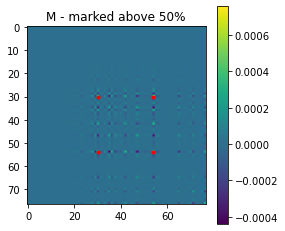

In [61]:
# fit the graph
gd_opt_params['Theta0'] = None
fact_B, fact_stats = sg.fit_graph(train_data['des'], train_data['lbls'], sg_params, gd_opt_params, seed)
fact_M = fact_B.T @ fact_B
visualize_M(fact_M, fig_params)

In [62]:
# GLR
fact_train_mse, fact_y_train_est, fact_t = sg.get_acc(fact_M, train_data['des'], train_data['lbls'], train_data['des'], train_data['lbls'], sg_params, 'cat', seed, show_edges)
train_r2 = r2_score(train_data['lbls'], fact_y_train_est)
train_acc = sum(np.round(fact_y_train_est.reshape(-1)) == train_data['lbls'].reshape(-1)) / train_num

print("Mean Squared Error on the TRAIN DATA:", fact_train_mse)
print("R-squared Score on the TRAIN DATA:", train_r2)
print("Prediction Accuracy on the TRAIN DATA:", train_acc)

Mean Squared Error on the TRAIN DATA: 1.845857243152197e-06
R-squared Score on the TRAIN DATA: 0.9999998745841973
Prediction Accuracy on the TRAIN DATA: 1.0


## Validate the GLR model

In [63]:
# import importlib
# importlib.reload(sg)

In [78]:
temp = np.array(sg_params['edges_vt'])
temp[:,1]

array([ 0,  1,  2, ..., 97, 98, 99])

In [64]:
show_edges = False

In [81]:
# GLR
fact_val_mse, fact_y_val_est, fact_t = sg.get_acc(fact_M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, 'cat', seed, show_edges)
val_r2 = r2_score(val_data['lbls'], fact_y_val_est)
val_acc = sum(np.round(fact_y_val_est.reshape(-1)) == val_data['lbls'].reshape(-1)) / val_num

print("Mean Squared Error on the VALIDATION DATA:", fact_val_mse)
print("R-squared Score on the VALIDATION DATA:", val_r2)
print("Prediction Accuracy on the VALIDATION DATA:", val_acc)

Mean Squared Error on the VALIDATION DATA: 19.039728897951875
R-squared Score on the VALIDATION DATA: -0.6587441540590913
Prediction Accuracy on the VALIDATION DATA: 0.26


# Compare GLR, LR and XGBoost

Number of training datapoints: 100
Number of features for each point: 77
mu = 30
   0: eps = 2.66e-02;  train loss (E) =  4.18
  10: eps = 6.54e-04;  train loss (E) =  0.20
  20: eps = 4.12e-03;  train loss (E) =  0.10
  30: eps = 3.24e-03;  train loss (E) =  0.09
  40: eps = 1.28e-03;  train loss (E) =  0.09
  50: eps = 2.01e-03;  train loss (E) =  0.09
  60: eps = 1.58e-03;  train loss (E) =  0.09
  70: eps = 1.25e-03;  train loss (E) =  0.09
  80: eps = 1.96e-03;  train loss (E) =  0.09
  90: eps = 3.09e-03;  train loss (E) =  0.09
  99: eps = 1.43e-03;  train loss (E) =  0.09
Number of training datapoints: 100
Number of features for each point: 77
mu = 30
   0: eps = 2.66e-02;  train loss (E) =  4.15
  10: eps = 1.31e-03;  train loss (E) =  0.17
  20: eps = 1.03e-03;  train loss (E) =  0.03
  30: eps = 1.62e-03;  train loss (E) =  0.03
  40: eps = 1.28e-03;  train loss (E) =  0.03
  50: eps = 1.01e-03;  train loss (E) =  0.03
  60: eps = 3.17e-03;  train loss (E) =  0.03
  70: eps 

F:\Users/yasam/Documents/GitHub/simgraph/code/my_packages\simgraph\my_simgraph.py:899: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4,4))


Number of training datapoints: 150
Number of features for each point: 77
mu = 30
   0: eps = 2.66e-02;  train loss (E) =  4.43
  10: eps = 5.23e-03;  train loss (E) =  0.29
  20: eps = 2.06e-03;  train loss (E) =  0.14
  30: eps = 1.62e-03;  train loss (E) =  0.13
  40: eps = 2.55e-03;  train loss (E) =  0.13
  50: eps = 2.01e-03;  train loss (E) =  0.13
  60: eps = 3.17e-03;  train loss (E) =  0.13
  70: eps = 2.49e-03;  train loss (E) =  0.13
  80: eps = 1.96e-03;  train loss (E) =  0.13
  90: eps = 1.55e-03;  train loss (E) =  0.13
  99: eps = 1.43e-03;  train loss (E) =  0.13
Number of training datapoints: 150
Number of features for each point: 77
mu = 30
   0: eps = 2.66e-02;  train loss (E) =  4.16
  10: eps = 5.23e-03;  train loss (E) =  0.14
  20: eps = 2.06e-03;  train loss (E) =  0.09
  30: eps = 1.62e-03;  train loss (E) =  0.09
  40: eps = 1.28e-03;  train loss (E) =  0.09
  50: eps = 2.01e-03;  train loss (E) =  0.09
  60: eps = 1.58e-03;  train loss (E) =  0.09
  70: eps 

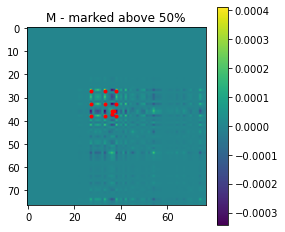

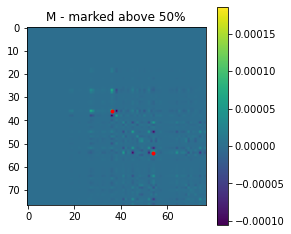

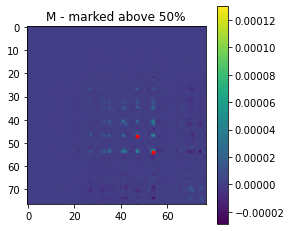

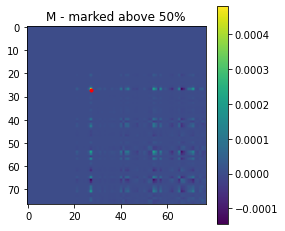

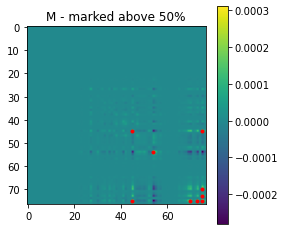

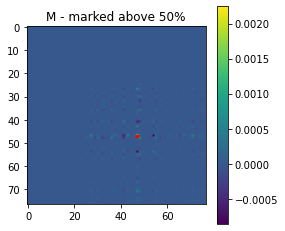

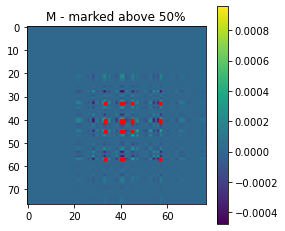

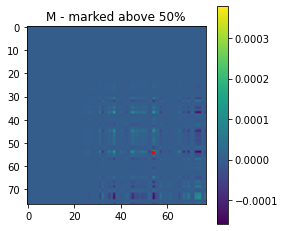

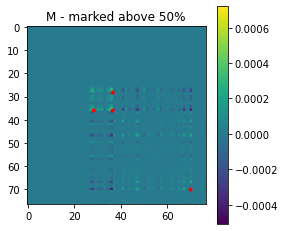

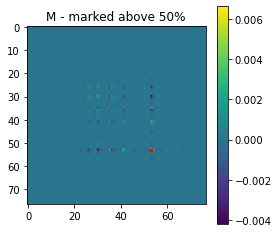

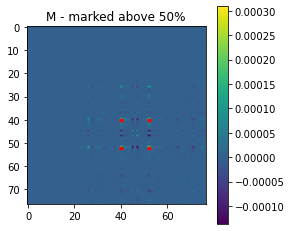

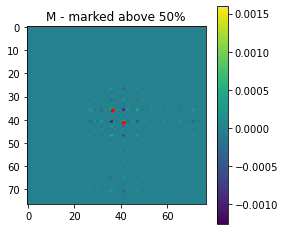

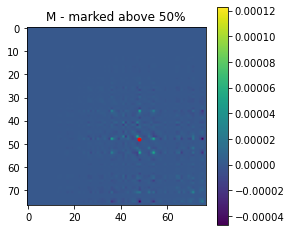

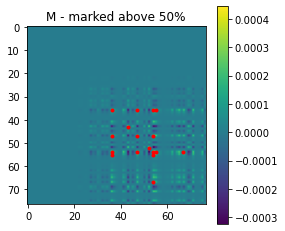

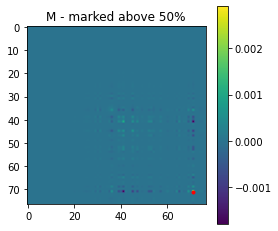

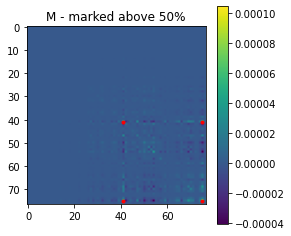

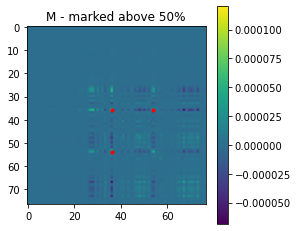

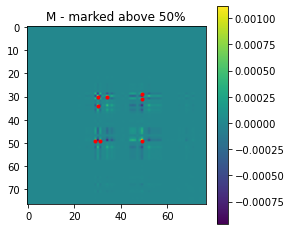

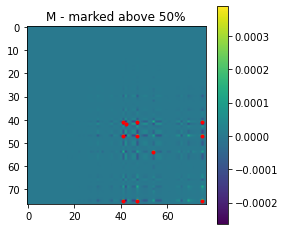

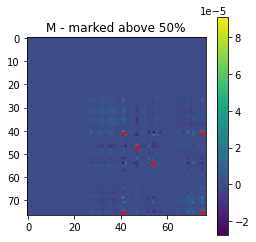

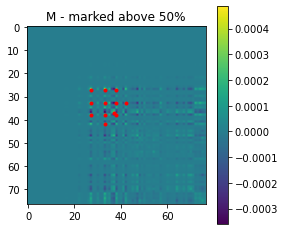

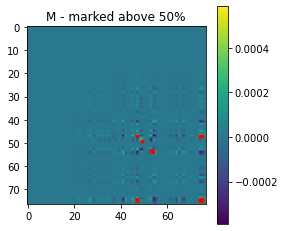

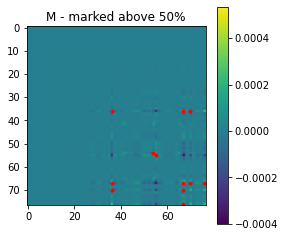

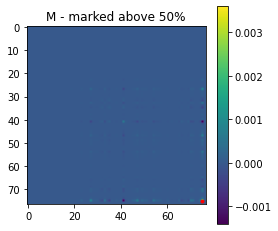

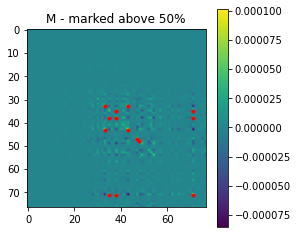

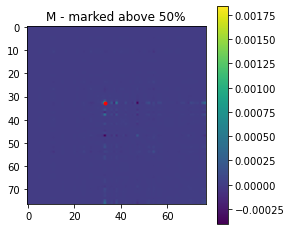

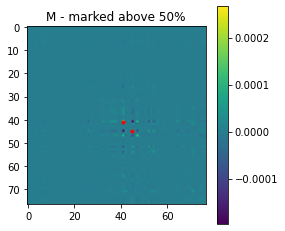

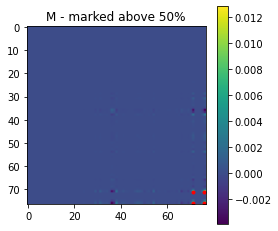

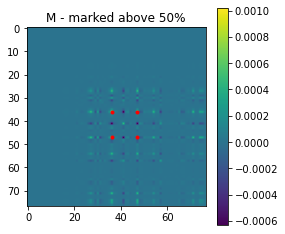

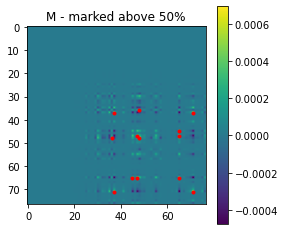

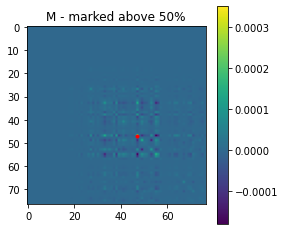

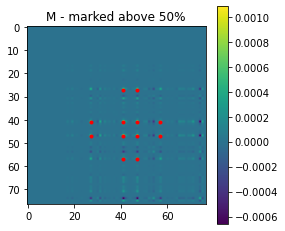

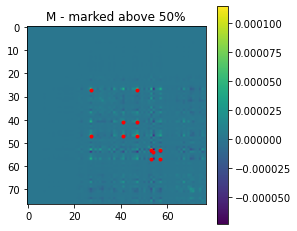

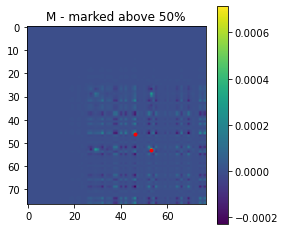

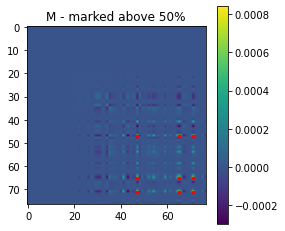

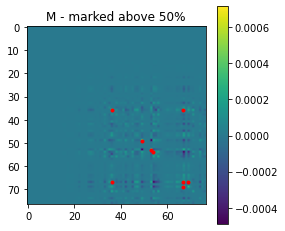

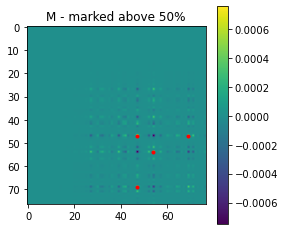

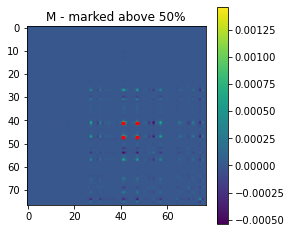

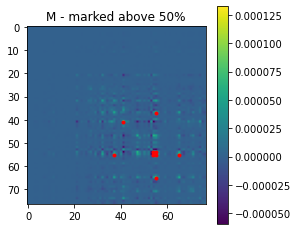

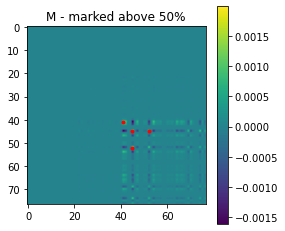

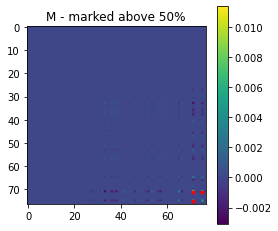

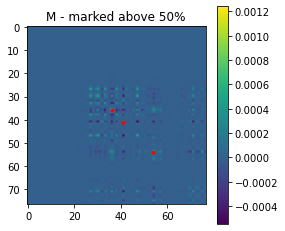

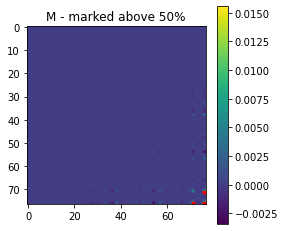

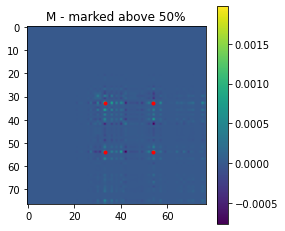

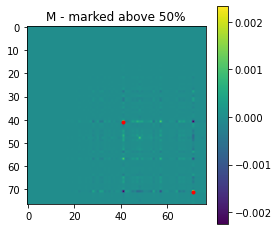

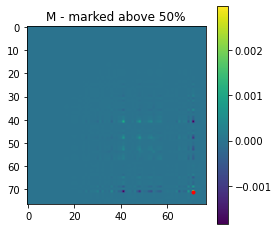

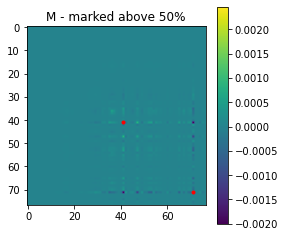

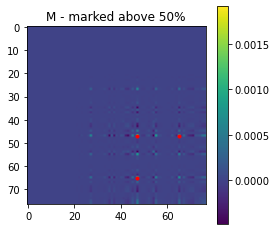

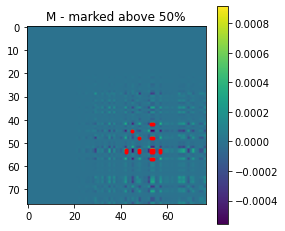

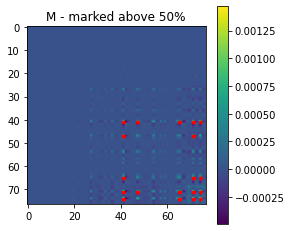

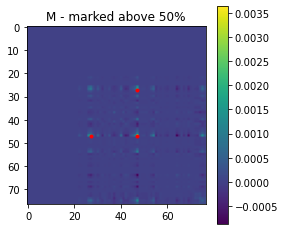

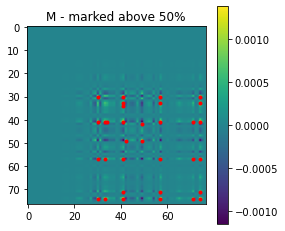

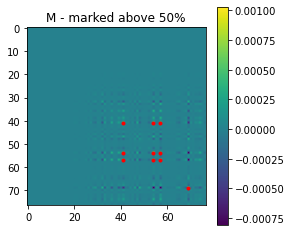

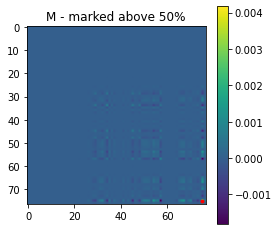

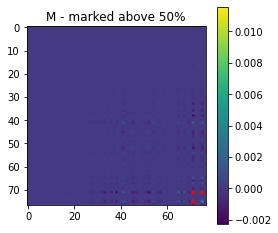

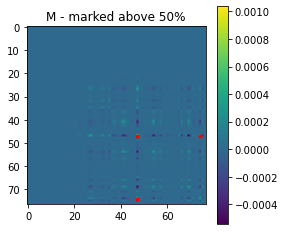

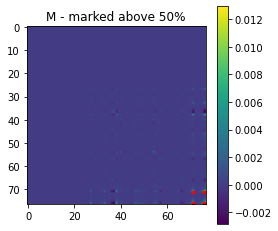

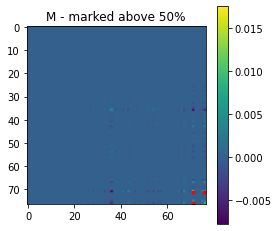

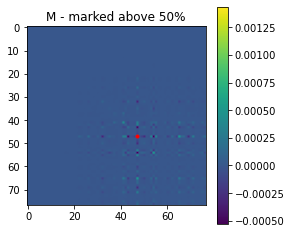

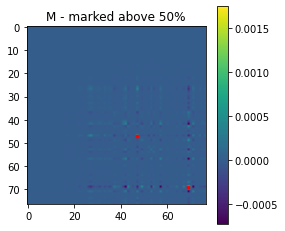

In [117]:
train_sizes = [100, 150, 200]
rpt = 20

xgb_mse = []
xgb_r2 = []
xgb_acc = []
lr_mse = []
lr_r2 = []
lr_acc = []
glr_mse = []
glr_r2 = []
glr_acc = []

for train_sz in train_sizes:
    for it in range(rpt):
        train_num = train_sz
        val_num = 50

        train_num, val_num, train_data, val_data = \
        dh.random_train_val(train_num, val_num, data_params, seed=None)

        # create a dataframe from the features array
        train_df = pd.DataFrame(data = train_data['des'])
        val_df = pd.DataFrame(data = val_data['des'])
        train_y = pd.DataFrame(data = train_data['lbls'])
        val_y = pd.DataFrame(data = val_data['lbls'])

        #Creating an XGBoost regressor
        model = xgb.XGBRegressor()
        model.fit(train_df, train_y)
        val_predictions = model.predict(val_df)

        # Calculate the mean squared error and R-squared score
        val_mse = mean_squared_error(val_y, val_predictions)
        val_r2 = r2_score(val_y, val_predictions)
        val_acc = sum(np.round(val_predictions) == val_y.to_numpy().reshape(-1)) / val_num
        xgb_mse.append(val_mse)
        xgb_r2.append(val_r2)
        xgb_acc.append(val_acc)

        model = LinearRegression()
        model.fit(train_df, train_y)
        val_predictions = model.predict(val_df)

        val_mse = mean_squared_error(val_y, val_predictions)
        val_r2 = r2_score(val_y, val_predictions)
        val_acc = sum(np.round(val_predictions.reshape(-1)) == val_y.to_numpy().reshape(-1)) / val_num
        lr_mse.append(val_mse)
        lr_r2.append(val_r2)
        lr_acc.append(val_acc)

        # graph construction parameters (common for all three methods)
        sg_params = {'Dt': None, 'Dv': None, 'Dvt':None, 'mu': 30,\
                     'cnstr_method_tt': 'time-inc-ord', 'cnstr_method_vv': 'time-inc-ord', 'cnstr_method_vt': 'time',\
                     'train_t': None, 'val_t': None, \
                     'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

        # gradient descent parameters (only used for factobj1)
        gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                        'num_its':100, 'check_freq':10, 'print_checks':True, 'Theta0':None, \
                        'force_all_its': True, 'threshold': -1}

        # update sg_params
        sg_params['train_t'] = train_data['smpls']
        sg_params['val_t'] = val_data['smpls']

        # set edges
        sg_params['edges_tt'] = sg.get_edges_tt(train_data['lbls'], sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)

        # fit the graph
        gd_opt_params['Theta0'] = None
        fact_B, fact_stats = sg.fit_graph(train_data['des'], train_data['lbls'], sg_params, gd_opt_params, seed)
        fact_M = fact_B.T @ fact_B
        visualize_M(fact_M, fig_params)

        fact_val_mse, fact_y_val_est, fact_t = sg.get_acc(fact_M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, 'cat', seed, show_edges)
        val_r2 = r2_score(val_data['lbls'], fact_y_val_est)
        val_acc = sum(np.round(fact_y_val_est.reshape(-1)) == val_data['lbls'].reshape(-1)) / val_num
        glr_mse.append(fact_val_mse)
        glr_r2.append(val_r2)
        glr_acc.append(val_acc)

In [118]:
xgb_mse = np.array(xgb_mse).reshape((len(train_sizes), rpt))
xgb_r2 = np.array(xgb_r2).reshape((len(train_sizes), rpt))
xgb_acc = np.array(xgb_acc).reshape((len(train_sizes), rpt))

mean_xgb_mse = np.mean(xgb_mse, axis=1)
std_xgb_mse = np.std(xgb_mse, axis=1)
mean_xgb_r2 = np.mean(xgb_r2, axis=1)
std_xgb_r2 = np.std(xgb_r2, axis=1)
mean_xgb_acc = np.mean(xgb_acc, axis=1)
std_xgb_acc = np.std(xgb_acc, axis=1)

In [119]:
lr_mse = np.array(lr_mse).reshape((len(train_sizes), rpt))
lr_r2 = np.array(lr_r2).reshape((len(train_sizes), rpt))
lr_acc = np.array(lr_acc).reshape((len(train_sizes), rpt))

mean_lr_mse = np.mean(lr_mse, axis=1)
std_lr_mse = np.std(lr_mse, axis=1)
mean_lr_r2 = np.mean(lr_r2, axis=1)
std_lr_r2 = np.std(lr_r2, axis=1)
mean_lr_acc = np.mean(lr_acc, axis=1)
std_lr_acc = np.std(lr_acc, axis=1)

In [120]:
glr_mse = np.array(glr_mse).reshape((len(train_sizes), rpt))
glr_r2 = np.array(glr_r2).reshape((len(train_sizes), rpt))
glr_acc = np.array(glr_acc).reshape((len(train_sizes), rpt))

mean_glr_mse = np.mean(glr_mse, axis=1)
std_glr_mse = np.std(glr_mse, axis=1)
mean_glr_r2 = np.mean(glr_r2, axis=1)
std_glr_r2 = np.std(glr_r2, axis=1)
mean_glr_acc = np.mean(glr_acc, axis=1)
std_glr_acc = np.std(glr_acc, axis=1)

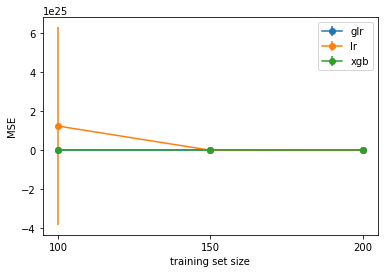

In [121]:
xs = np.arange(len(train_sizes))
plt.figure()
plt.errorbar(xs, mean_glr_mse, std_glr_mse, marker='o')
plt.errorbar(xs, mean_lr_mse, std_lr_mse, marker='o')
plt.errorbar(xs, mean_xgb_mse, std_xgb_mse, marker='o')
plt.xticks(xs, train_sizes)
plt.legend(['glr', 'lr', 'xgb'])
plt.ylabel('MSE')
plt.xlabel('training set size')
plt.savefig('mse_compare.png')

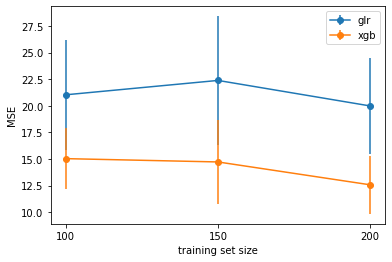

In [124]:
xs = np.arange(len(train_sizes))
plt.figure()
plt.errorbar(xs, mean_glr_mse, std_glr_mse, marker='o')
# plt.errorbar(xs, mean_lr_mse, std_lr_mse, marker='o')
plt.errorbar(xs, mean_xgb_mse, std_xgb_mse, marker='o')
plt.xticks(xs, train_sizes)
plt.legend(['glr', 'xgb'])
plt.ylabel('MSE')
plt.xlabel('training set size')
plt.savefig('mse_compare2.png')

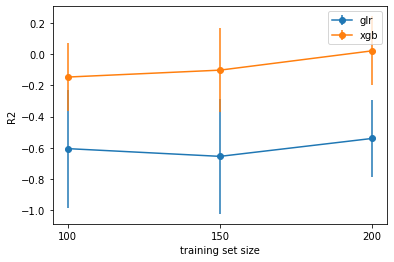

In [125]:
xs = np.arange(len(train_sizes))
plt.figure()
plt.errorbar(xs, mean_glr_r2, std_glr_r2, marker='o')
# plt.errorbar(xs, mean_lr_r2, std_lr_r2, marker='o')
plt.errorbar(xs, mean_xgb_r2, std_xgb_r2, marker='o')
plt.xticks(xs, train_sizes)
plt.legend(['glr', 'xgb'])
plt.ylabel('R2')
plt.xlabel('training set size')
plt.savefig('r2_compare.png')

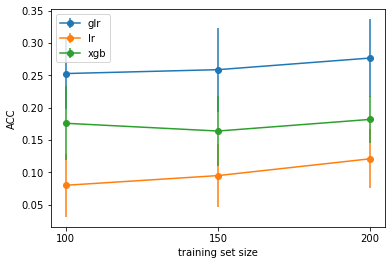

In [123]:
xs = np.arange(len(train_sizes))
plt.figure()
plt.errorbar(xs, mean_glr_acc, std_glr_acc, marker='o')
plt.errorbar(xs, mean_lr_acc, std_lr_acc, marker='o')
plt.errorbar(xs, mean_xgb_acc, std_xgb_acc, marker='o')
plt.xticks(xs, train_sizes)
plt.legend(['glr', 'lr', 'xgb'])
plt.ylabel('ACC')
plt.xlabel('training set size')
plt.savefig('acc_compare.png')